In [1]:
import os.path
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

(1000, 2)


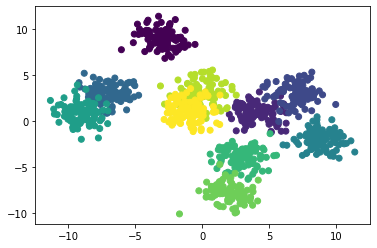

In [4]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data'].numpy()
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

print(data.shape)

Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000018B0595E608>, <pcurve.PrincipalCurve object at 0x0000018B05C73DC8>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000018B0595EA08>, <pcurve.PrincipalCurve object at 0x0000018B02BF2E48>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000018B0595EA08>, <pcurve.PrincipalCurve object at 0x0000018B02BF2E48>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000018B0595E608>, <pcurve.PrincipalCurve object at 0x0000018B05C73DC8>]


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


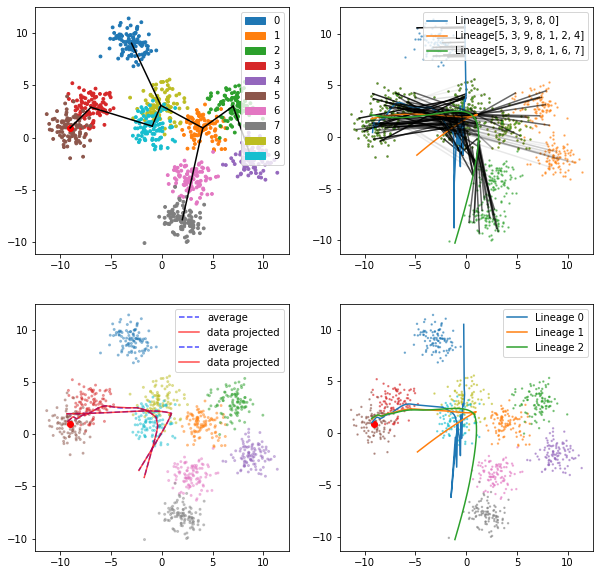

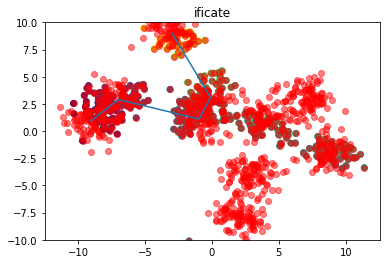

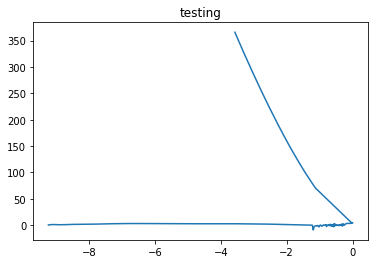

<Figure size 432x288 with 0 Axes>

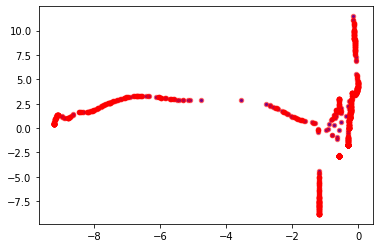

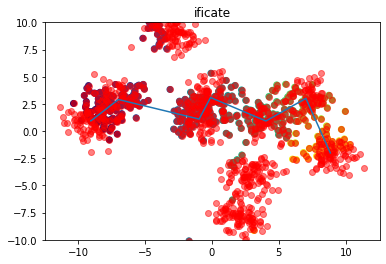

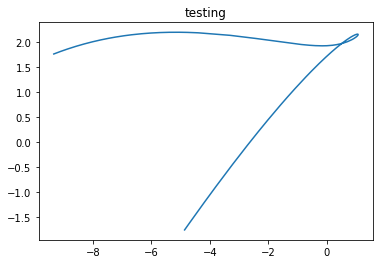

<Figure size 432x288 with 0 Axes>

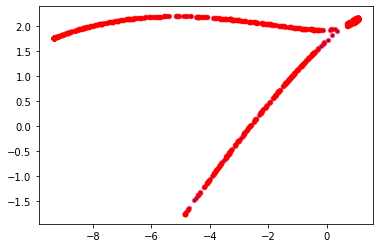

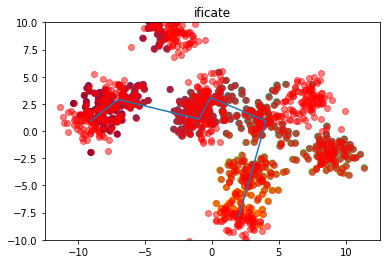

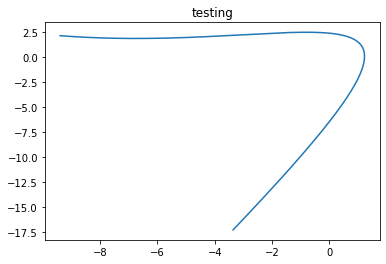

<Figure size 432x288 with 0 Axes>

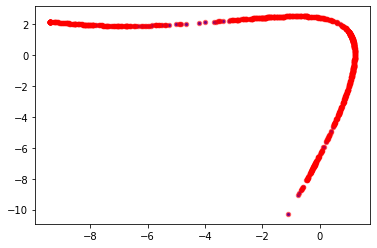

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
# plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

from slingshot import Slingshot

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_level='verbose')

slingshot.fit(num_epochs=1, debug_axes=axes)

In [9]:
print(slingshot.prev_curves[0].pseudotimes_interp)

[2.05225016e+01 1.92656397e+01 1.91374287e+01 1.85184032e+01
 1.76618065e+01 2.06385983e+01 1.87137715e+01 2.00065090e+01
 1.70339286e+01 1.87212942e+01 1.71247382e+01 2.01372363e+01
 1.83681521e+01 1.86276079e+01 1.97494196e+01 2.01704956e+01
 1.83606437e+01 1.93674216e+01 1.71564678e+01 1.94851442e+01
 2.03460539e+01 1.66551788e+01 1.74452699e+01 1.81125515e+01
 2.00546509e+01 1.82773146e+01 1.91639111e+01 1.69128492e+01
 1.94033246e+01 1.85571508e+01 1.91606138e+01 1.80235014e+01
 1.90196666e+01 1.80296292e+01 1.99539023e+01 2.02612929e+01
 1.92130336e+01 1.90308668e+01 1.70256324e+01 1.85594704e+01
 1.84732928e+01 2.03924638e+01 1.92611207e+01 1.88112196e+01
 1.69742581e+01 1.88893389e+01 1.87068254e+01 1.87601707e+01
 1.95007298e+01 2.06385983e+01 1.88869231e+01 1.85878230e+01
 1.93850367e+01 2.02581385e+01 1.93835418e+01 1.80079013e+01
 1.91927242e+01 1.80794867e+01 1.79344378e+01 1.89893183e+01
 1.79880712e+01 1.78924733e+01 1.90389563e+01 1.81640774e+01
 1.74640214e+01 1.718070

In [ ]:
tttttt


In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


